<a href="https://colab.research.google.com/github/Praveen76/Introduction-to-PyTorch/blob/main/Build_a_CNN_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment you will be able to :

* understand & build CNN  Model class in PyTorch
* train and test the model in PyTorch


### Dataset Description

The dataset choosen for this experiment is Fashion-MNIST. The dataset is made up of 28x28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category. The training set has 60,000 images and the test set has 10,000 images.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

**Labels / Classes**

0 - T-shirt/top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandal

6 - Shirt

7 - Sneaker

8 - Bag

9 - Ankle boot

## Importing the Required Packages

* First, we import pytorch, the deep learning library which we’ll be using, and torchvision, which provides our dataset and data transformations.

* We also import torch.nn (pytorch’s neural network library), torch.nn.functional (includes non-linear functions like ReLu and sigmoid) and torch.optim for implementing various optimization algorithms.

In [ ]:
# Importing torch packages
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Initializing CUDA

CUDA is used as an interface between our code and the GPU.

Normally, we run the code in the CPU. To run it in the GPU, we need CUDA. Check if CUDA is available:

In [ ]:
# To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 2.2.1+cu121 CUDA: True


If it's False, then we run the program on CPU. If it's True, then we run the program on GPU.

Let us initialize some GPU-related variables:

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

## Load Fashion MNIST data

Now, we'll load the Fashion MNIST data. For the first time, we may have to download the data, which can take a while.

Now,

* We will load both the training set and the testing sets

* We will use  transform.compose() to convert the datasets into tensors using transforms.ToTensor(). We also normalize them by setting the mean and standard deviation using transforms.Normalize().



In [ ]:
# Normalize the data with mean and std (0.2860 and 0.3530 are the mean and std for Fashion MNIST data)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.2860,), (0.3530,))])

In [ ]:
# Downloading the Training set
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train=True, transform=transform, download=True)

In [ ]:
# Verifying mean and std of Fashion MNIST data
trainset.data.float().mean() / 255, trainset.data.float().std() / 255

(tensor(0.2860), tensor(0.3530))

In [ ]:
# Loading the downloaded training set
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)

In [ ]:
# Downloading the testing set
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', train= False, transform=transform, download=True)

In [ ]:
# Loading the downloaded testing set
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=64)

The train and test data are provided via data loaders that provide iterators over the datasets.

The first element of training data (X_train) is a 4th-order tensor of size (batch_size, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. y_train is a vector containing the correct classes ("0", "1", ..., "9") for each training image. Here batch size is 64.


In [ ]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


## Plotting the images of 9 classes

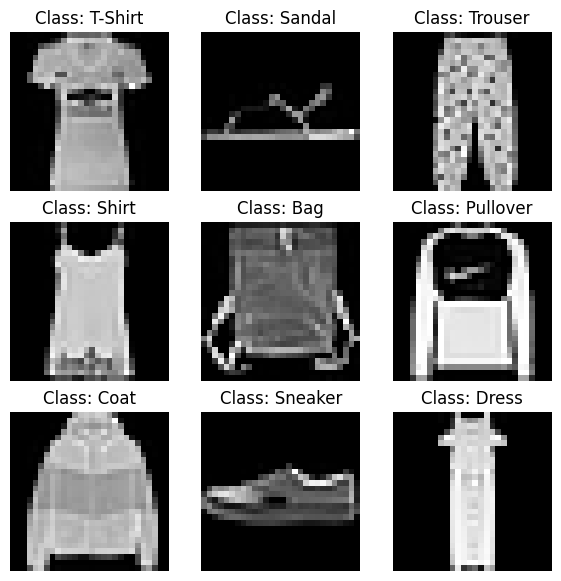

In [ ]:
labels =[]
features = []
for X,y in zip(X_train, y_train):
  # Getting unique labels
  if y not in labels:
    labels.append(y)
    features.append(X)

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
pltsize=1
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.axis('off')
    # Convert the tensor to numpy for displaying the image
    plt.imshow(features[i].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+labels_map[int(str(labels[i].numpy()))])


## Defining the CNN’s Architecture

In [ ]:
class Model(nn.Module):
    def __init__(self):
        #super(Model, self).__init__()  # Python 2 preferred
        super().__init__()  # Python 3 preferred method
        # Defining first convolution layer with input_channels = 1, output_channels = 8, kernel_size = 3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)

        # Defining second convolution layer with input_channels = 8, output_channels = 16, kernel_size = 3
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)

        # Define the Fully connected layers
        # The output of the second convolution layer will be input to the first fully connected layer
        self.fc1 = nn.Linear(16*5*5, 256)
        # 256 input features, 128 output features
        self.fc2 = nn.Linear(256, 128)
        # 128 input features, 64 output features
        self.fc3 = nn.Linear(128, 64)
        # 64 input features, 10 output features for our 10 defined classes
        self.fc4 = nn.Linear(64, 10)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2)  # Max pooling layer with filter size 2x2

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the image
        x = x.view(-1, 16*5*5)  # Output shape of convolutional layer is 16*5*5

        # Linear layers with RELU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

#### Calling the instances of the network

In [ ]:
model = Model()
model = model.to(device)
model

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, input_size=(1,28,28), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 8, 26, 26]              80
         MaxPool2d-2             [1, 8, 13, 13]               0
            Conv2d-3            [1, 16, 11, 11]           1,168
         MaxPool2d-4              [1, 16, 5, 5]               0
            Linear-5                   [1, 256]         102,656
            Linear-6                   [1, 128]          32,896
            Linear-7                    [1, 64]           8,256
            Linear-8                    [1, 10]             650
Total params: 145,706
Trainable params: 145,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.56
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


#### Defining the loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#### Training and Evaluating the model

In Training Phase, we iterate over a batch of images in the train_loader. For each batch, we perform  the following steps:

* First we zero out the gradients using zero_grad()

* We pass the data to the model i.e. we perform forward pass by calling the forward()

* We calculate the loss using the actual and predicted labels

* Perform Backward pass using backward() to update the weights

In [ ]:
# No of Epochs
epoch = 2

# keeping the network in train mode
model.train()
train_losses,  train_accuracy = [], []

# Loop for no of epochs
for e in range(epoch):
    train_loss = 0
    correct = 0
    # Iterate through all the batches in each epoch
    for images, labels in trainloader:

      # Convert the image and label to gpu for faster execution
      images = images.to(device)
      labels = labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Passing the data to the model (Forward Pass)
      outputs = model(images)

      # Calculating the loss
      loss = criterion(outputs, labels)
      train_loss += loss.item()

      # Performing backward pass (Backpropagation)
      loss.backward()

      # optimizer.step() updates the weights accordingly
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()

    # Accuracy calculation
    train_losses.append(train_loss/len(trainset))
    train_accuracy.append(100 * correct/len(trainset))
    print('epoch: {}, Train Loss:{:.6f} Train Accuracy: {:.2f} '.format(e+1,train_losses[-1], train_accuracy[-1]))

epoch: 1, Train Loss:0.009114 Train Accuracy: 77.92 
epoch: 2, Train Loss:0.005880 Train Accuracy: 86.05 


In Testing Phase, we iterate over a batch of images in the test_loader. For each batch we perform the following steps:

* We pass the images through the model (network) to get the outputs
* Pick the class / label with the highest probability
* Calculate the accuracy

In [ ]:
# Keeping the network in evaluation mode
model.eval()

Test_accuracy = 0

# Iterate through all the batches in each epoch
for images,labels in testloader:

    # Convert the images and labels to gpu for faster execution
    images = images.to(device)
    labels = labels.to(device)

    # Do the forward pass
    outputs = model(images)

    # Accuracy calculation
    _, predicted = torch.max(outputs, 1)
    Test_accuracy += (predicted == labels).sum().item()

Accuracy = 100 * Test_accuracy / len(testset)
print("Accuracy of Test Data is", Accuracy)

Accuracy of Test Data is 87.13
